In [ ]:
# Copyright 2021 Google LLC

# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at

#     http://www.apache.org/licenses/LICENSE-2.0

# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# BigQuery Audit Log Anomaly Detection
This example uses BigQuery Data Access Audit logs (cloudaudit_googleapis_com_data_access_*) to identify outlier and anomalous usage within your BigQuery data environment - it uses estimated cost (calculated by $5USD/TB) and total Tables Processed per job as the metric to identify anomalies. 

This example show cases two methods for identifying anomalies: 
1. <b> Outliers in groups: </b> This method looks for a datapoint that differs signicantly from others. This means that it identifies users who use BQ way more or less than others. 
2.  <b> Time Series Analysis: </b> Looking for outliers in periodic trends by looking at audit logs chronologically. This method has an underlying assumption that BigQuery usage has trends.

Other possible metrics include: 
* 'runtimeMs',
* 'runtimeSecs',
* 'lagtimeMs',
* 'lagtimeSecs',
* 'totalLoadOutputBytes',
* 'totalSlotMs',
* 'avgSlotsMS',
* 'totalTablesProcessed',
* 'totalViewsProcessed',
* 'totalProcessedBytes',
* 'totalBilledBytes',
* 'querylength', 
* 'estimatedCostUsd', 

## Setup
This cell downloads all requirements and creates required views for analysis.

In [ ]:
! echo "Installing Dependencies..."
! pip install -r requirements.txt || echo 'Error installing other dependencies'
! jupyter nbextension enable --py widgetsnbextension
! jupyter serverextension enable voila --sys-prefix

In [1]:
from google.cloud import bigquery
import os
from dotenv import load_dotenv
import viewsFactory as Vf
from google.cloud import bigquery
from google.cloud.exceptions import NotFound
from IPython.display import display, Markdown, Latex
import ipywidgets as widgets
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import chart_studio.plotly as py
import plotly.graph_objs as go
import plotly.express as px
from plotly.offline import iplot, init_notebook_mode
import cufflinks as cf
import plotly.io as pio
cf.go_offline()
init_notebook_mode(connected='true')
from ipywidgets import HBox, VBox, IntSlider, interactive_output, FloatSlider, interact, interact_manual
from traitlets import directional_link

In [2]:
jupyter = 'plotly_mimetype+notebook_connected'
github = 'svg'

# Comment out the Github line and Uncomment the jupyter line when running in jupyter to see interactive graphs
pio.renderers.default = github
# pio.renderers.default = jupyter

### Importing environment variables

In [3]:
%reload_ext autoreload
%autoreload 2
load_dotenv("var.env")

project_id       = os.environ.get("project_id")
data_project_id  = os.environ.get("data_project_id")
dataset_id       = os.environ.get("dataset_id")
audit_log_table  = os.environ.get("audit_log_table")
location         = os.environ.get("location")
audit_log_partitioned = (os.environ.get("audit_log_partitioned") == "True")

## Destination View 
destination_project_id   = os.environ.get("destination_project_id")
destination_dataset_id   = os.environ.get("destination_dataset_id")
summary_table_name       = os.environ.get("summary_table_name")

In [4]:
def query_to_df(query):
    """Run query string in BigQuery and return pandas dataframe from query result"""
    query_job = client.query(
        query,
        # Location must match that of the dataset(s) referenced in the query.
        location=location,
    )  # API request - starts the query

    df = query_job.to_dataframe()
    return df

### Creating summary view of Audit Log table

In [ ]:
# %%capture
client = bigquery.Client(location=location, project=project_id)
print("Client creating using default project: {}".format(client.project))

view = Vf.CreateView(project_id, data_project_id, dataset_id, audit_log_table, location, audit_log_partitioned, 
                     destination_project_id, destination_dataset_id, summary_table_name) 

view.create_all_job_view()

## Understanding the data - distributions and statistics
This section shows an example of a function to help in understanding the data for different metrics. Change the metric variable `metric_understanding` if you want to explore a different metric. 

<b>Note:</b> Since the values are Log Values, metrics which has zero values the below query will error with a ln(0) error, remove the `LOG` in the query if that happens.

In [6]:
# Distribution and Statistic plots Controls
metric_understanding = 'estimatedCostUsd'

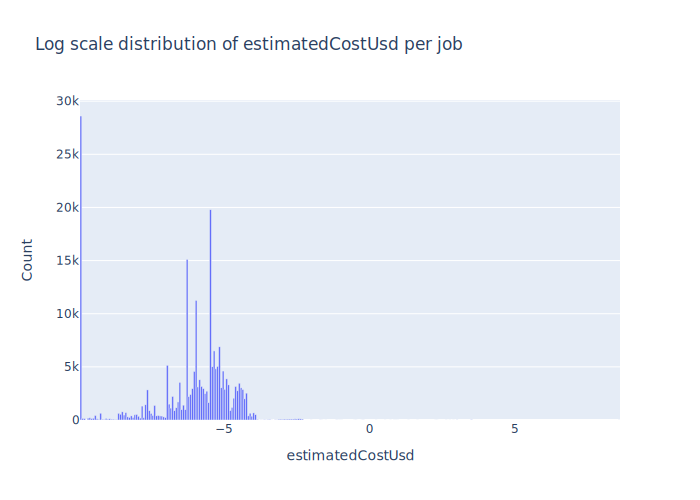

<p> <b> Descriptive Statistics for estimatedCostUsd:</b></p>

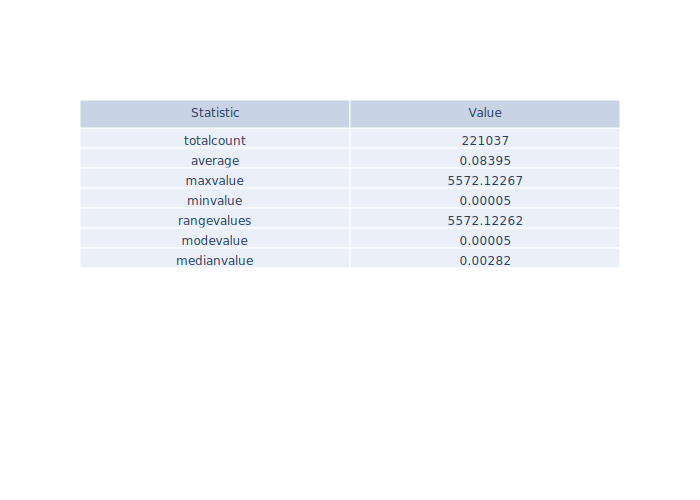

In [7]:
buck_query = """
            SELECT
              MAX(LOG({metric})) AS maxvalue,
              MIN(LOG({metric})) AS minvalue
            FROM
              `{project_id}.{destination_dataset_id}.{summary_table_name}`
            WHERE
              {metric} IS NOT NULL
              AND {metric} <> 0
            """.format(project_id = destination_project_id, 
                       destination_dataset_id = destination_dataset_id , 
                       summary_table_name = summary_table_name,
                       metric = metric_understanding)

buk_df = query_to_df(buck_query)
buckets = []
val = buk_df.minvalue[0]
for r in range(300+1): 
    buckets.append(val)
    val += (abs(buk_df.maxvalue[0] - buk_df.minvalue[0]))/300


dist_metric_query = """
                   WITH
                      help AS (
                      SELECT
                        bucket,
                        CONCAT(IFNULL(ranges[SAFE_OFFSET(bucket - 1)],
                            0), '-', ranges[SAFE_OFFSET(bucket)]) AS prange,
                        COUNT(*) AS countmetric,
                        MAX(IFNULL(ranges[SAFE_OFFSET(bucket - 1)],
                            0)) AS startRange,
                        MAX(ranges[SAFE_OFFSET(bucket)]) AS endRange
                      FROM
                        `{project_id}.{destination_dataset_id}.{summary_table_name}`,
                        UNNEST([STRUCT({buckets} AS ranges)]),
                        UNNEST([RANGE_BUCKET(LOG({metric}),
                            ranges)]) bucket
                      WHERE
                        {metric} IS NOT NULL
                        AND {metric} <> 0
                      GROUP BY
                        1,
                        2
                      ORDER BY
                        bucket )
                    SELECT
                      *
                    FROM
                      help
                    WHERE
                      prange IS NOT NULL
                """.format(project_id = destination_project_id, 
                           destination_dataset_id = destination_dataset_id , 
                           summary_table_name = summary_table_name,
                           metric = metric_understanding,
                           buckets = buckets
                           )
    
dist_metric_df = query_to_df(dist_metric_query)

fig = go.Figure(data=[go.Bar(
x=dist_metric_df['startRange'] + 0.5*(dist_metric_df['endRange'] - dist_metric_df['startRange']),
y=dist_metric_df['countmetric'],
width=dist_metric_df['endRange'] - dist_metric_df['startRange'], 
customdata = dist_metric_df.to_numpy(),
hovertemplate='<b>Range: %{customdata[1]}</b><br>Count: %{customdata[2]:.3f}<br>',
)])


fig.update_layout(title_text='Log scale distribution of {} per job'.format(metric_understanding), 
                  xaxis_title_text=metric_understanding, # xaxis label
                  yaxis_title_text='Count',)

fig.show()

stat_query = """
                WITH
                  mode AS (
                  SELECT
                    {metric} AS modevalue,
                  FROM
                    `{proj}.{ds}.{summ}`
                  WHERE
                    {metric} <> 0
                    AND {metric} IS NOT NULL
                  GROUP BY
                    {metric}
                  ORDER BY
                    COUNT(*) DESC
                  LIMIT
                    1 )
                SELECT
                  COUNT(NULLIF(main.{metric},
                      0)) AS totalcount,
                  AVG({metric}) AS average,
                  MAX({metric}) AS maxvalue,
                  MIN({metric}) AS minvalue,
                  MAX({metric}) - MIN({metric}) AS rangevalues,
                  MAX(modevalue) AS modevalue,
                  MAX(medianvalue) AS medianvalue,
                FROM
                  `{proj}.{ds}.{summ}` main,
                  mode,
                  (
                  SELECT
                    PERCENTILE_CONT({metric},
                      0.5) OVER() AS medianvalue
                  FROM
                    `{proj}.{ds}.{summ}`
                  LIMIT
                    1 )
                WHERE
                  {metric} <> 0
                  AND {metric} IS NOT NULL
            """.format(metric=metric_understanding, 
                       proj=destination_project_id, 
                       ds=destination_dataset_id, 
                       summ=summary_table_name)

stats_df = query_to_df(stat_query)
stats_df = stats_df.T.round(5)

fig = go.Figure(data=[go.Table(header=dict(values=['Statistic', 'Value']),
             cells=dict(values=[stats_df.index, stats_df.iloc[:, 0]]))
                 ])
display(Markdown('<p> <b> Descriptive Statistics for {}:</b></p>'.format(metric_understanding)))
fig.show()


***
## 1. Outliers in groups
Generate insights of usage patterns around different groups (which can be one of the following: 'principalEmail', 'eventName', 'projectId', 'dayOfWeek', 'hourOfDay'). This provides information on anomalous usage and pinpoints areas for strategic optimization. 

In [8]:
# Outlier Group Analysis controls
metric_outlier = 'estimatedCostUsd' # The query metric to investigate.
group          =  "principalEmail" # Group to identify outliers in
sigma          = 1.5 # Value of SD from mean to be considered an outlier.

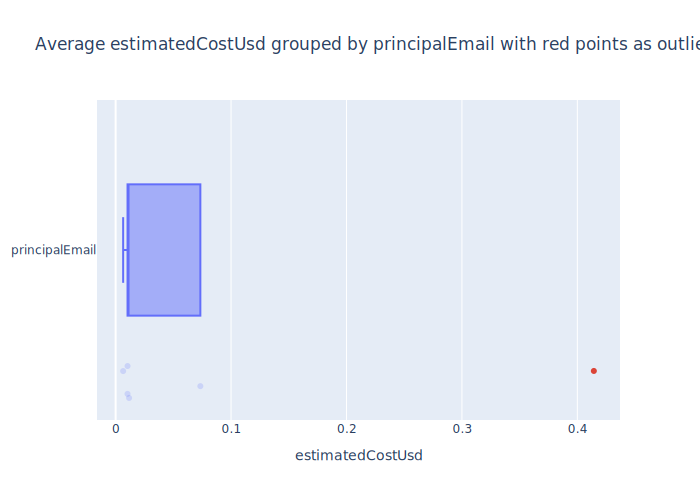

<h2> Summary </h2>

<p> Hover over the datapoints in the plot to see the group labels. </p>

<h4> The biggest outlier found is: <b>josie@example.com </b> with an average of       0.41 which is     2.0157 SD from the mean. </h4>

In [9]:
metric_query = """ WITH
                      get_metrics AS (
                      SELECT
                        {group} AS groupedby,
                        AVG({metric}) AS aggaverage,
                        AVG(AVG({metric})) OVER () AS mean,
                        STDDEV(AVG({metric})) OVER () AS sd
                      FROM
                        `{project_id}.{destination_dataset_id}.{summary_table_name}`
                      GROUP BY
                        groupedby)
                    SELECT
                      groupedby,
                      aggaverage,
                      (aggaverage - mean)/sd AS zscore,
                    IF
                      (ABS((aggaverage - mean)/sd) > {out},
                        1,
                        0) AS outlier
                    FROM
                      get_metrics
                    ORDER BY
                      zscore DESC
                """.format(metric = metric_outlier, 
                           group = group, 
                           project_id = destination_project_id, 
                           destination_dataset_id = destination_dataset_id , 
                           summary_table_name = summary_table_name, 
                           out = sigma)
metric_df    = query_to_df(metric_query)


fig = go.Figure()
fig.add_trace(go.Box(
                x        = metric_df["aggaverage"],
                pointpos = -2,
                opacity  = 1,
                customdata = metric_df.to_numpy(),
                name     = group,
                hovertemplate='<b>%{customdata[0]}</b><br><br>Aggregated Average: %{customdata[1]:.3f}<br>SD from Mean: %{customdata[2]:.3f}',
                boxpoints = "all",
                selectedpoints = metric_df[metric_df['outlier']==1].index,
                selected = dict(marker = dict( color = "#DB4437", opacity = 1)), 
                text=metric_df["aggaverage"], 
                ))

fig.update_layout(
    title="Average {metric} grouped by {group} with red points as outliers > {sd} sd from mean".format(metric=metric_outlier, group=group, sd=sigma), 
    xaxis_title= metric_outlier)

biggest = metric_df[metric_df['outlier']==1]    
fig.show()

display(Markdown('<h2> Summary </h2>'))
display(Markdown('<p> Hover over the datapoints in the plot to see the group labels. </p>'))


if biggest.empty: 
    display(Markdown('<h4> There are no outliers greater than your selection of {sigma} SD from the mean. </h4>'.format(sigma=sigma)))
else:
    display(Markdown('<h4> The biggest outlier found is: <b>{} </b> with an average of {:10.2f} which is {:10.4f} SD from the mean. </h4>'.format(metric_df[metric_df['outlier']==1].iloc[0].groupedby, 
                                                                                                                                     metric_df[metric_df['outlier']==1].iloc[0].aggaverage, 
                                                                                                                                     metric_df[metric_df['outlier']==1].iloc[0].zscore)))

***
# 2. Time Series Analysis

Uses 'totalTablesProcessed' as the metric for analysis. The analysis is carried out as follows: 
1. Calculated the average totalTablesProcessed per query per hour.
2. Carry out STL composition to decompose the time series into Seasonlity and Trend which is used to calculate an estimate: <br>
`estimation = trend + seasonal`
3. Outliers are determined by finding the difference between the estimated reconstructed time series and the actual value (residual). Any residual above a sigma threshold (user defined) is flagged as an outlier in the plot below. 

In [10]:
from statsmodels.tsa.seasonal import STL
from plotly.subplots import make_subplots
from scipy import fftpack
from traitlets import directional_link
import datetime

In [11]:
# Time Series Controls
metric_time = 'totalTablesProcessed' # The query metric to investigate.
sigma_time  = 3 # Value of SD from mean to be considered an outlier.
time        = 'HOUR' # The time interval to aggregate on. For example, selecting HOUR will generate an hourly average of the selected metric.
period      = 24 # Taking each day as one cyclic period.

In [12]:
# Query for STL decomposition
stl_query = """
        SELECT
          AVG({metric}) AS avgmetric,
          TIMESTAMP_TRUNC(createTime, {time}) AS time
        FROM
          `{project_id}.{destination_dataset_id}.{summary_table_name}`
        GROUP BY
          2
        ORDER BY
          2
        """.format(project_id = destination_project_id, 
                   destination_dataset_id = destination_dataset_id , 
                   summary_table_name = summary_table_name,
                   metric = metric_time, 
                   time = time)    


stl_o_df    = query_to_df(stl_query)

In [13]:
#STL DECOMPOSITION
stl_df = stl_o_df.reset_index()
stl_df = stl_df.set_index('time').drop(columns = ['index'])
stl = STL(stl_df, period=period)
result = stl.fit()
seasonal, trend, resid = result.seasonal, result.trend, result.resid
estimated = trend + seasonal
resid_mu = resid.mean()
resid_dev = resid.std()

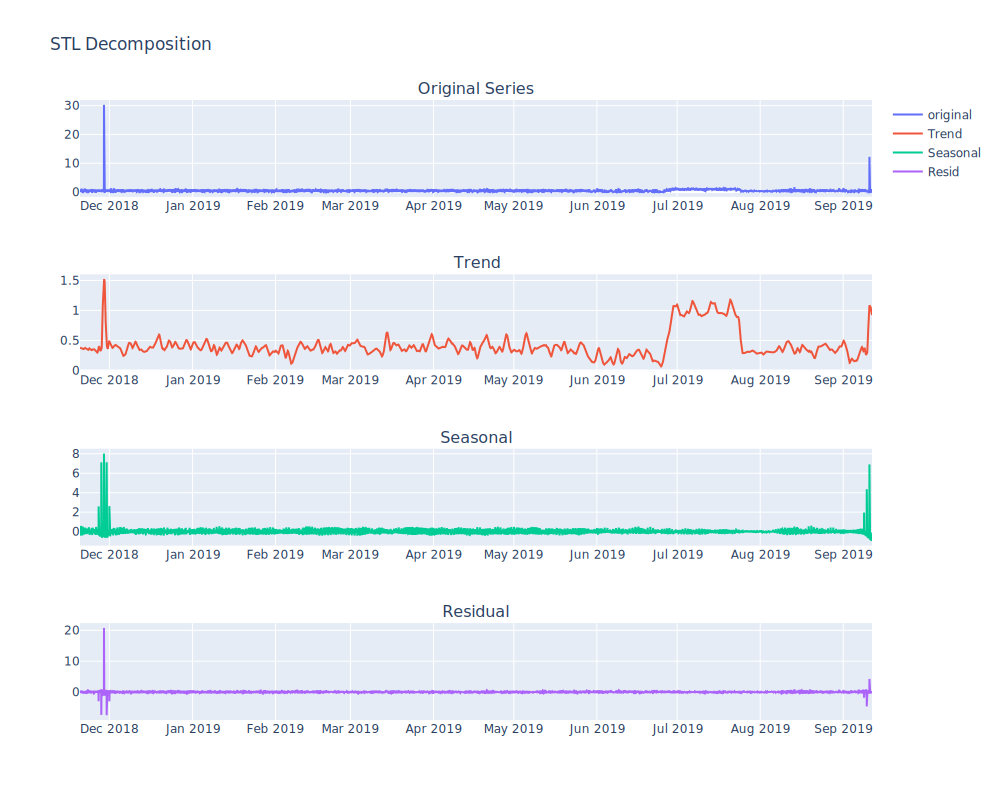

<p> <b> Outliers are detected if their residual (estimation - actual) is more than 3 from the residual mean </b></p>

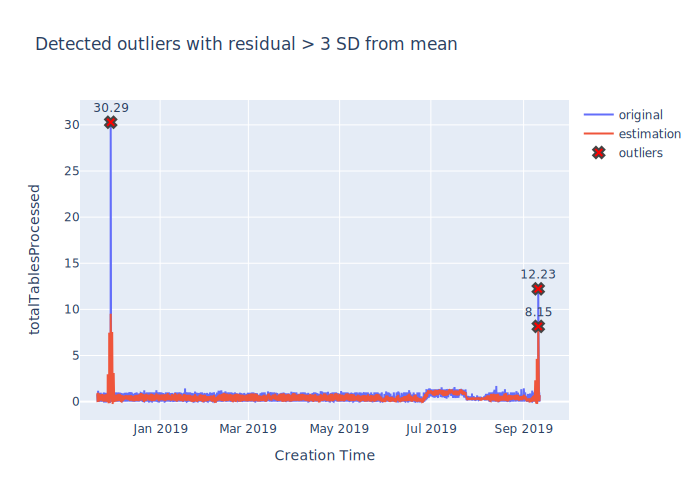

<h2> Summary </h2>

<p> <b> There are potential outliers in the following HOUR(s): </b></p>

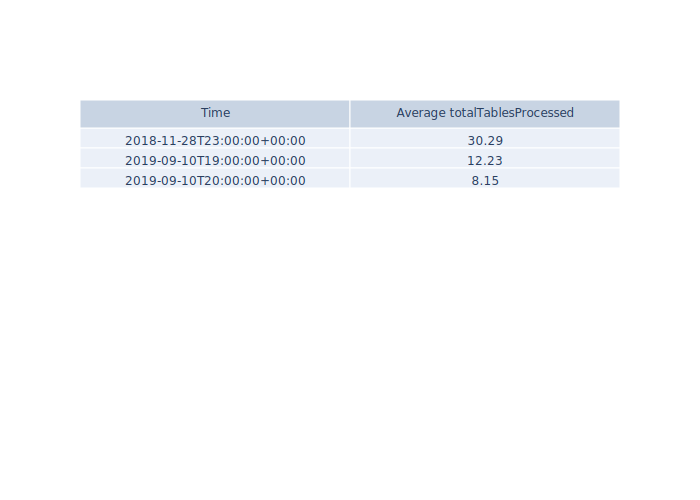

In [14]:
# Plots for STL 
fig_2 = make_subplots(rows=4, cols=1, row_heights=[15 for x in range(4)],
                specs=[[{'type':'xy'}], [{'type':'xy'}], [{'type':'xy'}], [{'type':'xy'}]], 
                horizontal_spacing = 0.2, 
                subplot_titles=['Original Series', 'Trend','Seasonal','Residual'])


fig_2.add_trace(go.Scatter(x=stl_df.index, y=stl_df['avgmetric'], name='original'), 1,1)
fig_2.add_trace(go.Scatter(x=trend.index, y=trend, name='Trend'), 2,1)
fig_2.add_trace(go.Scatter(x=seasonal.index, y=seasonal, name='Seasonal'), 3,1)
fig_2.add_trace(go.Scatter(x=resid.index, y=resid, name='Resid'), 4,1)

fig_2.update_layout(
    autosize=True,
    width=1000,
    height=800,
    title='STL Decomposition')

fig_2.show()

upper = resid_mu + sigma_time*resid_dev
anomalies = stl_df[(resid > upper)]

fig = go.Figure()
fig.add_trace(go.Scatter(x=stl_df.index, y=stl_df['avgmetric'], name='original'))
fig.add_trace(go.Scatter(x=estimated.index, y=estimated, name='estimation'))
fig.add_trace(go.Scatter(x=anomalies.index, y=anomalies.avgmetric,
                        mode='markers+text',
                        marker=dict(color='red'),
                        marker_symbol='x',
                        marker_line_width=2, 
                        marker_size=10,
                        name='outliers', 
                        textposition="top center",
                        text=np.round(anomalies.avgmetric.values, 2)))


display(Markdown('<p> <b> Outliers are detected if their residual (estimation - actual) is more than {sigma} from the residual mean </b></p>'.format(sigma=sigma_time)))
fig.update_layout(
            title="Detected outliers with residual > {sigma} SD from mean".format(sigma=sigma_time), 
            xaxis_title="Creation Time", 
            yaxis_title=metric_time
                    )    

fig.show()
anomalies = anomalies.round(2)
fig = go.Figure(data=[go.Table(header=dict(values=['Time', 'Average {}'.format(metric_time)]),
             cells=dict(values=[anomalies.index, anomalies.avgmetric] ))
                 ])
display(Markdown('<h2> Summary </h2>'))

if anomalies.empty:
    display(Markdown('<h4> There are no outliers greater than your selection of {sigma} SD from the mean. </h4>'.format(sigma=sigma_time)))

else:
    display(Markdown('<p> <b> There are potential outliers in the following {}(s): </b></p>'.format(time)))
    fig.show()